In [147]:
import os
import wave
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import librosa
import librosa.display
import soundfile
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's set some parameters:

In [148]:
seed = 12345
dir_source = os.path.abspath('../data/recordings')
dir_trimmed = os.path.abspath('../data/trimmed')
dir_unified = os.path.abspath('../data/unified')
dir_mel = os.path.abspath('../data/mel')
dir_mfcc = os.path.abspath('../data/mfcc/')


Let's collect names of all source files:

In [149]:
print('Source directory: ' + dir_source)
files_wav = os.listdir(dir_source)
print('Source files: ' + str(len(files_wav)))

Source directory: /Users/dmitry/Documents/Clemson/AML/project/data/recordings
Source files: 3000


The first step would be unify the number of channels.
Let's understand if it's required for our dataset:

In [150]:
ch = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    ch.append(f.getnchannels())
    f.close()
print('Unique channel number: ' + str(len(set(ch))))

100%|██████████| 3000/3000 [00:00<00:00, 4127.97it/s]

Unique channel number: 1


Let's understand how many channels our files have:

In [151]:
f = wave.open(dir_source + '/' + files_wav[0], 'rb')
print('Channels: ' + str(f.getnchannels()))
f.close()

Channels: 1


It means all our files have one channel (mono). For different numbers of channels we would have two options:
- downscale a number of channels for all files to 1
- upscale a number of channels for all files to the maximum of all files

The first option is simpler as for the second one we would need to handle the situation when the maximum is 3, but some files have 2 channels with different content.

The second step would be unify the sample rate.
Let's understand if it's required for our dataset:

In [152]:
rt = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    rt.append(f.getframerate())
    f.close()
print('Unique sample rate number: ' + str(len(set(rt))))

100%|██████████| 3000/3000 [00:00<00:00, 16749.68it/s]

Unique sample rate number: 1


The third step is to unify the duration.
As we have just mono files, we can calulate a duration for each file in the next way and understand if we need to unify it:

In [153]:
dur = []
for fname in tqdm(files_wav):
    f = wave.open(dir_source + '/' + fname, 'rb')
    dur.append(f.getnframes() / float(f.getframerate()))
    f.close()
print('Unique duration number: ' + str(len(set(dur))))

100%|██████████| 3000/3000 [00:00<00:00, 18056.87it/s]

Unique duration number: 2056


It means we need to unify the duration for all files.

Let's start with removing silence from all files:

In [154]:
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_source + '/' + fname, sr = 8000, mono = True)
    clip = librosa.effects.trim(audio, top_db = 10)
    soundfile.write(dir_trimmed + '/' + fname, clip[0], sr)

100%|██████████| 3000/3000 [00:03<00:00, 774.25it/s]


Now let's find the maximum duration among all files:

In [155]:
dur_max = 0
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_trimmed + '/' + fname, sr = 8000, mono = True)
    dur_max = dur_max if dur_max > audio.shape[0] else audio.shape[0]
print('Max duration: ' + str(dur_max))

100%|██████████| 3000/3000 [00:00<00:00, 4923.50it/s]

Max duration: 6457


And now let's unify duration for all files:

In [156]:
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_trimmed + '/' + fname, sr = 8000, mono = True)
    clip = librosa.util.pad_center(data = audio, size = dur_max)
    soundfile.write(dir_unified + '/' + fname, clip, sr)

100%|██████████| 3000/3000 [00:02<00:00, 1032.69it/s]


Now let's check the result:

In [157]:
dur = []
for fname in tqdm(files_wav):
    f = wave.open(dir_unified + '/' + fname, 'rb')
    dur.append(f.getnframes() / float(f.getframerate()))
    f.close()
print('Unique duration number: ' + str(len(set(dur))))

100%|██████████| 3000/3000 [00:00<00:00, 8669.14it/s]

Unique duration number: 1


Let's calculate mel spectrograms for our files:

In [158]:
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_unified + '/' + fname, sr = 8000, mono = True)
    mel = librosa.feature.melspectrogram(y = audio, sr = sr)
    np.savetxt(dir_mel + '/' + fname.replace('.wav', '.mel'), mel)

100%|██████████| 3000/3000 [00:39<00:00, 75.62it/s] 


Let's try to plot one of these files:

5_nicolas_9.wav


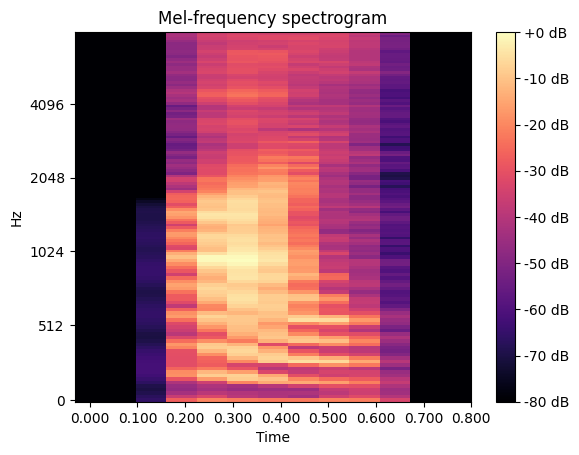

In [159]:
mel = np.loadtxt(dir_mel + '/' + files_wav[0].replace('.wav', '.mel'))
fig, ax = plt.subplots()
mel_db = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(mel_db, x_axis = 'time', y_axis = 'mel', sr = sr, fmax = 8000, ax = ax)
fig.colorbar(img, ax = ax, format = '%+2.0f dB')
ax.set(title = 'Mel-frequency spectrogram')
print(files_wav[0])

Let's calculate MFCCs:

In [160]:
scaler = sklearn.preprocessing.StandardScaler()
for fname in tqdm(files_wav):
    audio, sr = librosa.load(dir_unified + '/' + fname, sr = 8000, mono = True)
    mfcc = librosa.feature.mfcc(audio, sr = sr)
    mfcc = scaler.fit_transform(mfcc)
    np.savetxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc'), mfcc)

100%|██████████| 3000/3000 [00:30<00:00, 96.79it/s] 


Let's split the dataset onto a training and a testing sets:

In [161]:
data_train, data_test = sklearn.model_selection.train_test_split(files_wav, random_state = seed)
print('Training set size: ' + str(len(data_train)))
print('Testing set size: ' + str(len(data_test)))

Training set size: 2250
Testing set size: 750


Let's create labels for our training and testing data:

In [162]:
data_train_label = []
data_test_label = []
for d in tqdm(data_train):
    data_train_label.append(d[0])
for d in tqdm(data_test):
    data_test_label.append(d[0])

100%|██████████| 750/750 [00:00<00:00, 1048925.64it/s]


When we use sklearn for SVM, the library provides 3 options of implementation: SVC, NuSVC and LinearSVC. The latter is, actually, not truly SVM as it minimizes squared hinge loss, instead of just hinge loss, that leads to penalizing the size of bias, and supports only linear kernels, so, effectively, there are 2 options - SVC and NuSVC. As the both implementations are almost identical, we will use SVC.

In [163]:
mfccs_train = []
for fname in tqdm(data_train):
    mfccs_train.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())
model_svc = sklearn.svm.SVC(kernel = 'rbf', random_state = seed)
model_svc.fit(mfccs_train, data_train_label)

mfccs_test = []
for fname in tqdm(data_test):
    mfccs_test.append(np.loadtxt(dir_mfcc + '/' + fname.replace('.wav', '.mfcc')).ravel())
model_svm_predict = predict = model_svc.predict(mfccs_test)


100%|██████████| 750/750 [00:00<00:00, 991.52it/s] 
